# Modeling
- **Import necessary libraries.**

In [1]:
# standard libraries
import numpy as np
import pandas as pd

# visualization libraries
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns; sns.set_style('ticks')

# modeling libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# saving libraries
import gzip
import pickle

# custom functions
from functions import *

# reload when functions is edited
%load_ext autoreload
%autoreload 2

from tqdm import tqdm

## Load dataframes

In [2]:
# uncomment to load
with gzip.open('data/5k_jan_thru_may_tweets_plus_features.pkl', 'rb') as hello:
    df = pickle.load(hello)

df.shape

(575949, 22)

In [3]:
df.columns

Index(['date', 'tweet', 'username', 'link', 'nlikes', 'nreplies', 'nretweets',
       'sentiment_score', 'sentiment', 'clean_tweet', 'lda_topic_max', 'lda_0',
       'lda_1', 'lda_2', 'lda_3', 'lda_4', 'lda_5', 'lda_6', 'lda_7', 'lda_8',
       'lda_9', 'subjectivity_score'],
      dtype='object')

In [4]:
with gzip.open('data/data_vec.pkl', 'rb') as hello:
    vectors_df = pickle.load(hello)
    
vectors_df.shape

(575949, 3712)

### Combine necessary features columns

In [5]:
feature_cols = ['nlikes', 'nreplies', 'nretweets', 'lda_0', 'lda_1', 'lda_2', 'lda_3', 'lda_4', 'lda_5',
                'lda_6', 'lda_7', 'lda_8', 'lda_9', 'subjectivity_score']

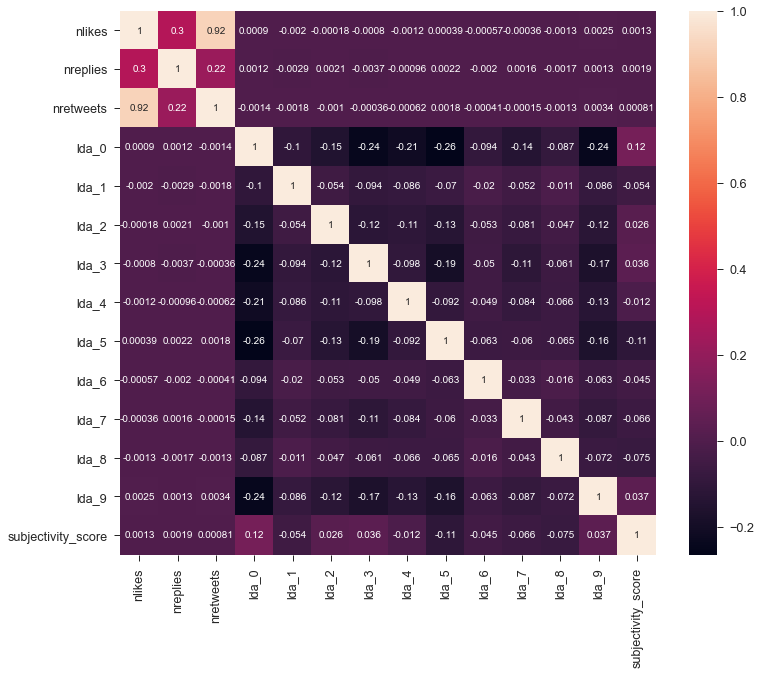

In [6]:
plt.figure(figsize=(12,10))
sns.heatmap(df[feature_cols].corr(), annot=True)

In [7]:
# drop nretweets
feature_cols = ['nlikes', 'nreplies', 'lda_0', 'lda_1', 'lda_2', 'lda_3', 'lda_4', 'lda_5',
                'lda_6', 'lda_7', 'lda_8', 'lda_9', 'subjectivity_score']

In [8]:
X = pd.concat([df[feature_cols], vectors_df], axis=1)
y = df['sentiment']

X.shape, y.shape

((575949, 3725), (575949,))

# Train Test Split

In [9]:
%%time

# split into train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=1)

# create vectors-only training and test sets (removing the first 13 columns)
X_train_vec = X_train.iloc[:,13:]
X_test_vec = X_test.iloc[:,13:]

X_train.shape, X_test.shape, X_train_vec.shape, X_test_vec.shape

((403164, 3725), (172785, 3725), (403164, 3712), (172785, 3712))

# MinMax Scaler

In [10]:
%%time

# MinMax Scaler for numerical data + vectors
mm_scaler = MinMaxScaler()
X_train_mm = mm_scaler.fit_transform(X_train)
X_test_mm = mm_scaler.transform(X_test)

CPU times: user 35.3 s, sys: 40.2 s, total: 1min 15s
Wall time: 1min 32s


# Bernoulli Naive Bayes - vectors only

In [11]:
%%time

# create Bernoulli Naive Bayes object
bnb_vec = BernoulliNB()

# train model
benaba_vec = bnb_vec.fit(X_train_vec, y_train)

# predict on corresponding test data
y_pred_bnb_vec = benaba_vec.predict(X_test_vec)

# checking accuracy
print('Test Accuracy score: ', accuracy_score(y_test, y_pred_bnb_vec))
# checking f1
print('Test F1 score: ', f1_score(y_test, y_pred_bnb_vec, average='weighted'))
# checking recall
print('Test Recall score: ', recall_score(y_test, y_pred_bnb_vec, average='weighted'))
# checking precision
print('Test Precision score: ', precision_score(y_test, y_pred_bnb_vec, average='weighted'))

Test Accuracy score:  0.7103741644239951
Test F1 score:  0.7125429945382699
Test Recall score:  0.7103741644239951
Test Precision score:  0.721267134872381
CPU times: user 1min 40s, sys: 33.3 s, total: 2min 13s
Wall time: 2min 15s


In [28]:
# top 10 most important features per class
pos_class_prob_sorted = benaba_vec.feature_log_prob_[0, :].argsort()
neu_class_prob_sorted = benaba_vec.feature_log_prob_[1, :].argsort()
neg_class_prob_sorted = benaba_vec.feature_log_prob_[2, :].argsort()


print(f'Positive tweets:\n{", ".join(list(np.take(X_train_vec.columns, pos_class_prob_sorted[:10])))}\n')
print(f'Neutral tweets:\n{", ".join(list(np.take(X_train_vec.columns, neu_class_prob_sorted[:9])))}\n')
print(f'Negative tweets:\n{", ".join(list(np.take(X_train_vec.columns, neg_class_prob_sorted[:10])))}')

Positive tweets:
#wholesale, okhand, #sale, faceblowingakiss, smilingfacewith3, #healthy, #safe, purpleheart, #love, blueheart

Neutral tweets:
incompetence, smilingfacewithheart, improve, incompetent, okhand, celebrate, #love, smilingfacewith3, violent

Negative tweets:
iniran, assault, thief, incompetence, suicide, germany's, #fight, fails, threatens, declares


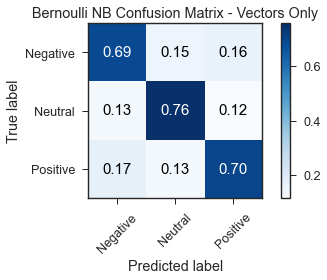

In [13]:
cm_benaba = confusion_matrix(y_test, y_pred_bnb_vec)
classes = ['Negative', 'Neutral', 'Positive']
plot_confusion_matrix(cm_benaba, classes, normalize=True,
                      title='Bernoulli NB Confusion Matrix - Vectors Only', cmap=plt.cm.Blues)

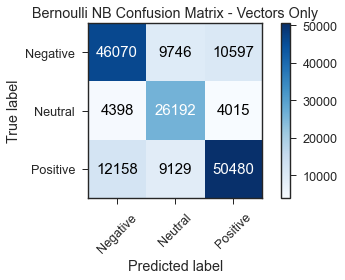

In [14]:
cm_benaba = confusion_matrix(y_test, y_pred_bnb_vec)
classes = ['Negative', 'Neutral', 'Positive']
plot_confusion_matrix(cm_benaba, classes, normalize=False,
                      title='Bernoulli NB Confusion Matrix - Vectors Only', cmap=plt.cm.Blues)

# Bernoulli Naive Bayes - numerical data + vectors

In [15]:
%%time

# create Bernoulli Naive Bayes object
bnb_combo = BernoulliNB()

# train model
benaba_combo = bnb_combo.fit(X_train_mm_combo, y_train)

# predict on corresponding test data
y_pred_bnb_combo = benaba_combo.predict(X_test_mm_combo)

# checking accuracy
print('Test Accuracy score: ', accuracy_score(y_test, y_pred_bnb_combo))
# checking f1
print('Test F1 score: ', f1_score(y_test, y_pred_bnb_combo, average='weighted'))
# checking recall
print('Test Recall score: ', recall_score(y_test, y_pred_bnb_combo, average='weighted'))
# checking precision
print('Test Precision score: ', precision_score(y_test, y_pred_bnb_combo, average='weighted'))

Test Accuracy score:  0.7032439158491767
Test F1 score:  0.7058146286649454
Test Recall score:  0.7032439158491767
Test Precision score:  0.7157080531925692
CPU times: user 1min 44s, sys: 46.5 s, total: 2min 31s
Wall time: 2min 36s


In [16]:
# top 10 most important features per class
pos_class_prob_sorted = benaba_combo.feature_log_prob_[0, :].argsort()
neu_class_prob_sorted = benaba_combo.feature_log_prob_[1, :].argsort()
neg_class_prob_sorted = benaba_combo.feature_log_prob_[2, :].argsort()

print(np.take(X.columns, pos_class_prob_sorted[:10]))
print(np.take(X.columns, neu_class_prob_sorted[:10]))
print(np.take(X.columns, neg_class_prob_sorted[:10]))

Index(['#wholesale', '#sale', 'okhand', 'faceblowingakiss', 'smilingfacewith3',
       '#healthy', 'purpleheart', '#safe', 'twohearts', 'blueheart'],
      dtype='object')
Index(['incompetent', 'smilingfacewithheart', '#love', 'celebrate', 'improve',
       'incompetence', 'smilingfacewith3', 'okhand', '#healthy',
       '#nomeatnocoronavirus'],
      dtype='object')
Index(['iniran', 'assault', 'thief', 'suicide', 'incompetence', 'germany's',
       '#fight', 'fails', 'threatens', 'violence'],
      dtype='object')


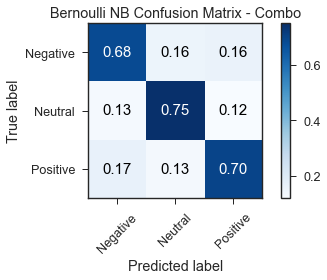

In [17]:
cm_benaba = confusion_matrix(y_test, y_pred_bnb_combo)
classes = ['Negative', 'Neutral', 'Positive']
plot_confusion_matrix(cm_benaba, classes, normalize=True,
                      title='Bernoulli NB Confusion Matrix - Combo', cmap=plt.cm.Blues)

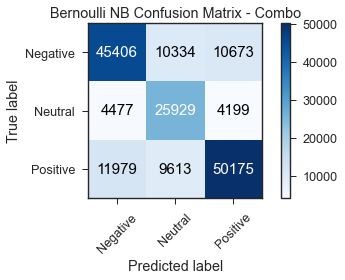

In [18]:
cm_benaba = confusion_matrix(y_test, y_pred_bnb_combo)
classes = ['Negative', 'Neutral', 'Positive']
plot_confusion_matrix(cm_benaba, classes, normalize=False,
                      title='Bernoulli NB Confusion Matrix - Combo', cmap=plt.cm.Blues)

# Multinomial Naive Bayes - vectors only

In [19]:
%%time

# create Multinomial Naive Bayes object
mnb_vec = MultinomialNB()

# train models using only MinMax scaler (Multinomial NB cannot work with negative values)
munaba_vec = mnb_vec.fit(X_train_vec, y_train)

# predict on corresponding test data
y_pred_mnb_vec = munaba_vec.predict(X_test_vec)

# checking accuracy
print('Test Accuracy score: ', accuracy_score(y_test, y_pred_mnb_vec))
# checking f1
print('Test F1 score: ', f1_score(y_test, y_pred_mnb_vec, average='weighted'))
# checking recall
print('Test Recall score: ', recall_score(y_test, y_pred_mnb_vec, average='weighted'))
# checking precision
print('Test Precision score: ', precision_score(y_test, y_pred_mnb_vec, average='weighted'))

Test Accuracy score:  0.6851578551378881
Test F1 score:  0.6723613950746848
Test Recall score:  0.6851578551378881
Test Precision score:  0.6870868114628952
CPU times: user 21.6 s, sys: 14.1 s, total: 35.7 s
Wall time: 32.9 s


In [20]:
# top 10 most important features per class
pos_class_prob_sorted = munaba_vec.feature_log_prob_[0, :].argsort()
neu_class_prob_sorted = munaba_vec.feature_log_prob_[1, :].argsort()
neg_class_prob_sorted = munaba_vec.feature_log_prob_[2, :].argsort()

print(np.take(X_train_vec.columns, pos_class_prob_sorted[:10]))
print(np.take(X_train_vec.columns, neu_class_prob_sorted[:10]))
print(np.take(X_train_vec.columns, neg_class_prob_sorted[:10]))

Index(['#wholesale', '#sale', 'okhand', 'smilingfacewith3', 'blueheart',
       'twohearts', 'faceblowingakiss', '#love', 'purpleheart', '#healthy'],
      dtype='object')
Index(['#love', 'incompetent', 'incompetence', 'improve',
       'smilingfacewithheart', 'smilingfacewith3', 'celebrate', 'okhand',
       'illegal', 'heartsuit'],
      dtype='object')
Index(['iniran', 'assault', 'thief', 'incompetence', 'suicide', 'fatality',
       'fails', 'threatens', 'swine', 'violence'],
      dtype='object')


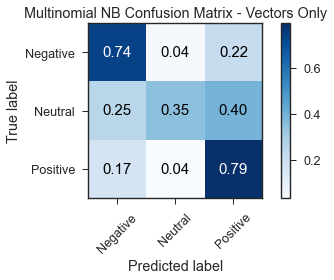

In [21]:
cm_munaba = confusion_matrix(y_test, y_pred_mnb_vec)
classes = ['Negative', 'Neutral', 'Positive']
plot_confusion_matrix(cm_munaba, classes, normalize=True,
                      title='Multinomial NB Confusion Matrix - Vectors Only', cmap=plt.cm.Blues)

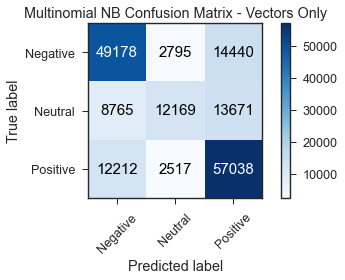

In [22]:
cm_munaba = confusion_matrix(y_test, y_pred_mnb_vec)
classes = ['Negative', 'Neutral', 'Positive']
plot_confusion_matrix(cm_munaba, classes, normalize=False,
                      title='Multinomial NB Confusion Matrix - Vectors Only', cmap=plt.cm.Blues)

# Multinomial Naive Bayes - numerical data + vectors

In [23]:
%%time

# create Multinomial Naive Bayes object
mnb_combo = MultinomialNB()

# train models using only MinMax scaler (Multinomial NB cannot work with negative values)
munaba_combo = mnb_combo.fit(X_train_mm_combo, y_train)

# predict on corresponding test data
y_pred_mnb_combo = munaba_combo.predict(X_test_mm_combo)

# checking accuracy
print('Test Accuracy score: ', accuracy_score(y_test, y_pred_mnb_combo))
# checking f1
print('Test F1 score: ', f1_score(y_test, y_pred_mnb_combo, average='weighted'))
# checking recall
print('Test Recall score: ', recall_score(y_test, y_pred_mnb_combo, average='weighted'))
# checking precision
print('Test Precision score: ', precision_score(y_test, y_pred_mnb_combo, average='weighted'))

Test Accuracy score:  0.6901351390456347
Test F1 score:  0.6812505031566807
Test Recall score:  0.6901351390456347
Test Precision score:  0.691852641702168
CPU times: user 22 s, sys: 14.1 s, total: 36.1 s
Wall time: 32.6 s


In [24]:
# top 10 most important features per class
pos_class_prob_sorted = munaba_combo.feature_log_prob_[0, :].argsort()
neu_class_prob_sorted = munaba_combo.feature_log_prob_[1, :].argsort()
neg_class_prob_sorted = munaba_combo.feature_log_prob_[2, :].argsort()

print(np.take(X.columns, pos_class_prob_sorted[:10]))
print(np.take(X.columns, neu_class_prob_sorted[:10]))
print(np.take(X.columns, neg_class_prob_sorted[:10]))

Index(['#wholesale', '#sale', 'okhand', 'smilingfacewith3', 'blueheart',
       'twohearts', 'faceblowingakiss', '#love', 'purpleheart', '#healthy'],
      dtype='object')
Index(['incompetent', '#love', 'celebrate', 'okhand', 'smilingfacewithheart',
       'improve', 'smilingfacewith3', 'incompetence', 'illegal', 'heartsuit'],
      dtype='object')
Index(['iniran', 'assault', 'thief', 'incompetence', 'suicide', 'nlikes',
       'fatality', 'fails', 'threatens', 'swine'],
      dtype='object')


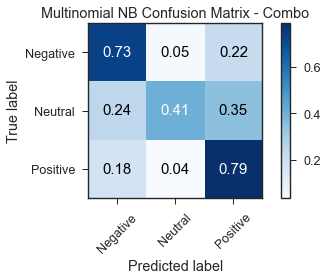

In [25]:
cm_munaba = confusion_matrix(y_test, y_pred_mnb_combo)
classes = ['Negative', 'Neutral', 'Positive']
plot_confusion_matrix(cm_munaba, classes, normalize=True,
                      title='Multinomial NB Confusion Matrix - Combo', cmap=plt.cm.Blues)

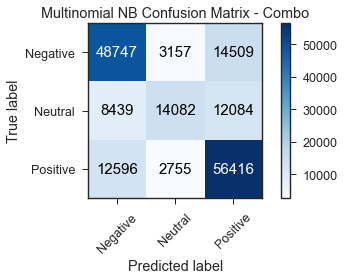

In [26]:
cm_munaba = confusion_matrix(y_test, y_pred_mnb_combo)
classes = ['Negative', 'Neutral', 'Positive']
plot_confusion_matrix(cm_munaba, classes, normalize=False,
                      title='Multinomial NB Confusion Matrix - Combo', cmap=plt.cm.Blues)

# Decision Tree - Basic - vectors only

In [27]:
%%time

# basic decision tree with class weights balanced
tree_vec = DecisionTreeClassifier(class_weight='balanced', random_state=99)

# fit training data
tree_vec.fit(X_train_vec, y_train)

# predict on test data
y_pred_tree_vec = tree_vec.predict(X_test_vec)

# check accuracy
print('Test Accuracy score: ', accuracy_score(y_test, y_pred_tree_vec))
# check f1
print('Test F1 score: ', f1_score(y_test, y_pred_tree_vec, average='weighted'))
# check recall
print('Test Recall score: ', recall_score(y_test, y_pred_tree_vec, average='weighted'))
# check precision
print('Test Precision score: ', precision_score(y_test, y_pred_tree_vec, average='weighted'))

Test Accuracy score:  0.7463089967300403
Test F1 score:  0.7461185808886704
Test Recall score:  0.7463089967300403
Test Precision score:  0.7462228871363354
CPU times: user 1h 17min 51s, sys: 32.3 s, total: 1h 18min 23s
Wall time: 1h 18min 52s


In [66]:
features_dict = dict(zip(X_train_vec.columns, tree_vec.feature_importances_))
sorted_d = sorted(features_dict.items(), key=lambda x: x[1], reverse=True)[:10]
sorted_d

[('protect', 0.015002061521935327),
 ('infected', 0.0136030874018215),
 ('help', 0.013411917375655547),
 ('safe', 0.012436975284261206),
 ('hand', 0.010648702215041278),
 ('death', 0.009271172889120289),
 ('fight', 0.009256208920213829),
 ('sick', 0.008989366286999562),
 ('please', 0.008836075804956623),
 ('stop', 0.008752192444228495)]

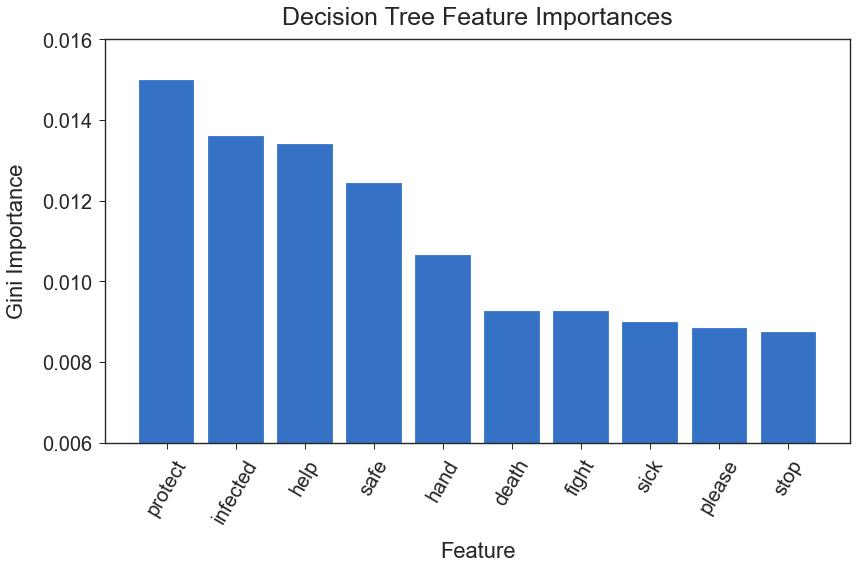

In [67]:
# top 10 most important features
tree_importance = [x[1] for x in sorted_d]

# prettify the graph
plt.figure(figsize=(12,8))
plt.title('Decision Tree Feature Importances', fontsize=25, pad=15)
plt.xlabel('Feature', fontsize=22, labelpad=15)
plt.ylabel('Gini Importance', fontsize=22, labelpad=15)
plt.ylim(bottom=0.006, top=0.016)
plt.xticks(rotation=60, fontsize=20)
plt.yticks(fontsize=20)

# plot
plt.bar([x[0] for x in sorted_d], tree_importance)

# # prepare to display and save
plt.tight_layout()
# uncomment to save
plt.savefig('charts/tree_feature_importance.png', bbox_inches='tight', transparent=True)

plt.show()

### Confusion Matrix

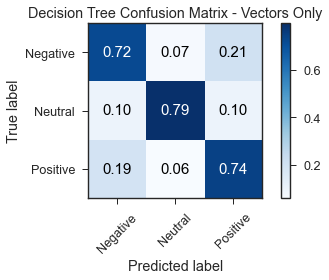

In [30]:
cm_tree = confusion_matrix(y_test, y_pred_tree_vec)
classes = ['Negative', 'Neutral', 'Positive']
plot_confusion_matrix(cm_tree, classes, normalize=True,
                      title='Decision Tree Confusion Matrix - Vectors Only', cmap=plt.cm.Blues)

# plt.savefig('Images/dt_conf_matrix.png', dpi = 100)

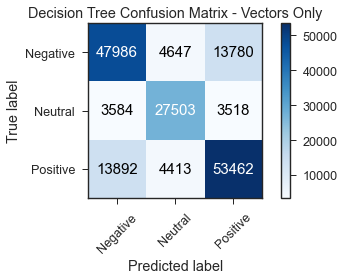

In [47]:
cm_tree = confusion_matrix(y_test, y_pred_tree_vec)
classes = ['Negative', 'Neutral', 'Positive']
plot_confusion_matrix(cm_tree, classes, normalize=False,
                      title='Decision Tree Confusion Matrix - Vectors Only', cmap=plt.cm.Blues)

# plt.savefig('Images/dt_conf_matrix.png', dpi = 100)

# Decision Tree - Basic - numerical data and vectors

In [31]:
%%time

# basic decision tree with class weights balanced
tree_combo = DecisionTreeClassifier(class_weight='balanced', random_state=99)

# fit training data
tree_combo.fit(X_train_mm_combo, y_train)

# predict on test data
y_pred_tree_combo = tree_combo.predict(X_test_mm_combo)

# check accuracy
print('Test Accuracy score: ', accuracy_score(y_test, y_pred_tree_combo))
# check f1
print('Test F1 score: ', f1_score(y_test, y_pred_tree_combo, average='weighted'))
# check recall
print('Test Recall score: ', recall_score(y_test, y_pred_tree_combo, average='weighted'))
# check precision
print('Test Precision score: ', precision_score(y_test, y_pred_tree_combo, average='weighted'))

Test Accuracy score:  0.6672454206094279
Test F1 score:  0.6673714307615696
Test Recall score:  0.6672454206094279
Test Precision score:  0.6677628462542978
CPU times: user 30min 53s, sys: 22.5 s, total: 31min 15s
Wall time: 31min 34s


In [38]:
features_dict = dict(zip(X.columns, tree_combo.feature_importances_))
sorted_d = sorted(features_dict.items(), key=lambda x: x[1], reverse=True)[:10]
sorted_d

[('subjectivity_score', 0.07797788105198546),
 ('lda_1', 0.03433683030205193),
 ('lda_8', 0.02683608918824314),
 ('lda_7', 0.021149959590798528),
 ('lda_3', 0.020923917553573215),
 ('lda_4', 0.020263526320849403),
 ('lda_9', 0.019942775582682346),
 ('lda_0', 0.019744969521788877),
 ('lda_5', 0.01940833897272871),
 ('lda_2', 0.018082717411740955)]

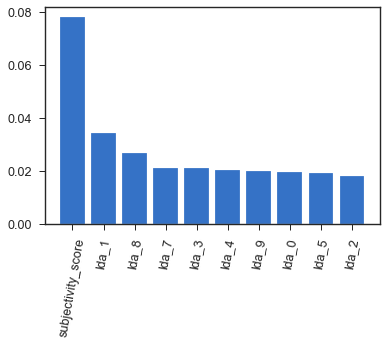

In [33]:
# top 10 most important features
tree_importance = [x[1] for x in sorted_d]

plt.bar([x[0] for x in sorted_d], tree_importance)
plt.xticks(rotation=80)
plt.show()

### Confusion Matrix

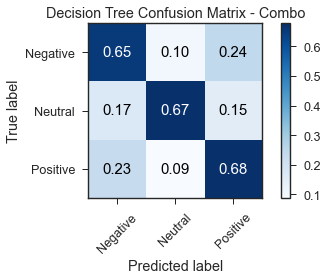

In [34]:
cm_tree = confusion_matrix(y_test, y_pred_tree_combo)
classes = ['Negative', 'Neutral', 'Positive']
plot_confusion_matrix(cm_tree, classes, normalize=True,
                      title='Decision Tree Confusion Matrix - Combo', cmap=plt.cm.Blues)

# plt.savefig('Images/dt_conf_matrix.png', dpi = 100)

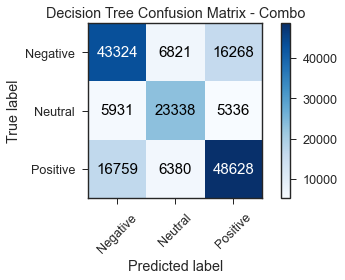

In [48]:
cm_tree = confusion_matrix(y_test, y_pred_tree_combo)
classes = ['Negative', 'Neutral', 'Positive']
plot_confusion_matrix(cm_tree, classes, normalize=False,
                      title='Decision Tree Confusion Matrix - Combo', cmap=plt.cm.Blues)

# plt.savefig('Images/dt_conf_matrix.png', dpi = 100)

# Decision Tree - Tuned - vectors only

In [62]:
%%time

# basic decision tree with class weights balanced
tree_vec_tuned = DecisionTreeClassifier(class_weight='balanced', max_depth=1000, random_state=99)

# fit training data
tree_vec_tuned.fit(X_train_vec, y_train)

# predict on test data
y_pred_tree_vec_tuned = tree_vec_tuned.predict(X_test_vec)

# check accuracy
print('Test Accuracy score: ', accuracy_score(y_test, y_pred_tree_vec_tuned))
# check f1
print('Test F1 score: ', f1_score(y_test, y_pred_tree_vec_tuned, average='weighted'))
# check recall
print('Test Recall score: ', recall_score(y_test, y_pred_tree_vec_tuned, average='weighted'))
# check precision
print('Test Precision score: ', precision_score(y_test, y_pred_tree_vec_tuned, average='weighted'))

Test Accuracy score:  0.750493387736204
Test F1 score:  0.7500162239363747
Test Recall score:  0.750493387736204
Test Precision score:  0.7505434573249348
CPU times: user 57min 7s, sys: 24.4 s, total: 57min 32s
Wall time: 57min 53s


In [68]:
features_dict = dict(zip(X_train_vec.columns, tree_vec_tuned.feature_importances_))
sorted_d = sorted(features_dict.items(), key=lambda x: x[1], reverse=True)[:10]
sorted_d

[('protect', 0.015351175304954078),
 ('infected', 0.014116004993446903),
 ('help', 0.013808042974950035),
 ('safe', 0.012906016907650962),
 ('hand', 0.011008175857333574),
 ('death', 0.00963822255784357),
 ('fight', 0.00949919417155364),
 ('sick', 0.009387514482172444),
 ('please', 0.009184770525423325),
 ('stop', 0.009134569628947112)]

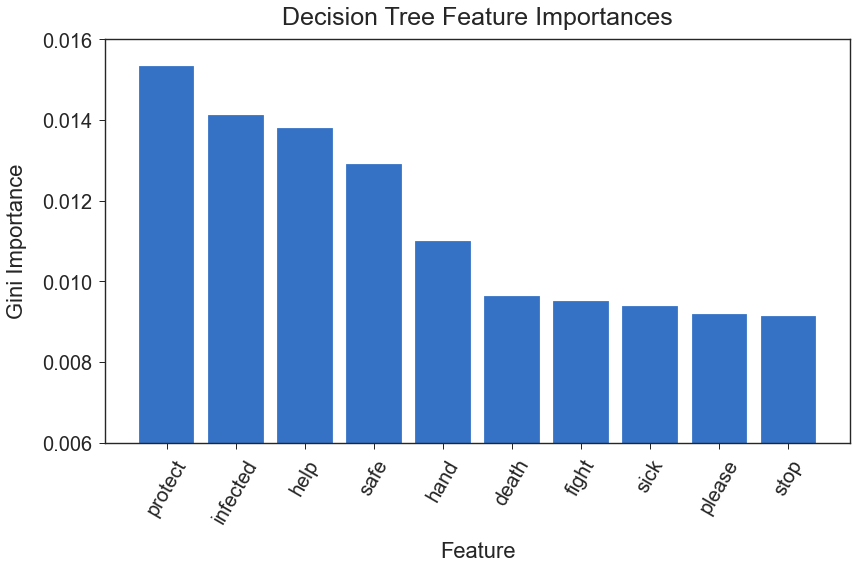

In [69]:
# top 10 most important features
tree_importance = [x[1] for x in sorted_d]

# prettify the graph
plt.figure(figsize=(12,8))
plt.title('Decision Tree Feature Importances', fontsize=25, pad=15)
plt.xlabel('Feature', fontsize=22, labelpad=15)
plt.ylabel('Gini Importance', fontsize=22, labelpad=15)
plt.ylim(bottom=0.006, top=0.016)
plt.xticks(rotation=60, fontsize=20)
plt.yticks(fontsize=20)

# plot
plt.bar([x[0] for x in sorted_d], tree_importance)

# # prepare to display and save
plt.tight_layout()
# uncomment to save
plt.savefig('charts/tuned_tree_feature_importance.png', bbox_inches='tight', transparent=True)

plt.show()

### Confusion Matrix

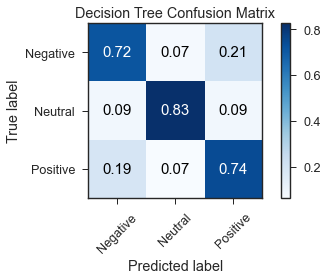

In [70]:
cm_tree = confusion_matrix(y_test, y_pred_tree_vec_tuned)
classes = ['Negative', 'Neutral', 'Positive']
plot_confusion_matrix(cm_tree, classes, normalize=True,
                      title='Decision Tree Confusion Matrix', cmap=plt.cm.Blues)

# plt.savefig('Images/dt_conf_matrix.png', dpi = 100)

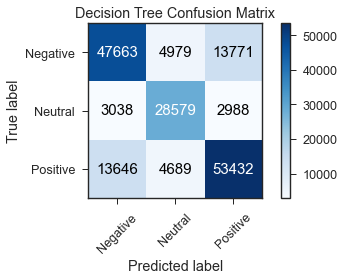

In [71]:
cm_tree = confusion_matrix(y_test, y_pred_tree_vec_tuned)
classes = ['Negative', 'Neutral', 'Positive']
plot_confusion_matrix(cm_tree, classes, normalize=False,
                      title='Decision Tree Confusion Matrix', cmap=plt.cm.Blues)

# plt.savefig('Images/dt_conf_matrix.png', dpi = 100)

# Decision Tree - Tuned - vectors only - v2

In [72]:
%%time

# basic decision tree with class weights balanced
tree_vec_tuned2 = DecisionTreeClassifier(class_weight='balanced', max_depth=500, random_state=99)

# fit training data
tree_vec_tuned2.fit(X_train_vec, y_train)

# predict on test data
y_pred_tree_vec_tuned2 = tree_vec_tuned2.predict(X_test_vec)

# check accuracy
print('Test Accuracy score: ', accuracy_score(y_test, y_pred_tree_vec_tuned2))
# check f1
print('Test F1 score: ', f1_score(y_test, y_pred_tree_vec_tuned2, average='weighted'))
# check recall
print('Test Recall score: ', recall_score(y_test, y_pred_tree_vec_tuned2, average='weighted'))
# check precision
print('Test Precision score: ', precision_score(y_test, y_pred_tree_vec_tuned2, average='weighted'))

Test Accuracy score:  0.744265995312093
Test F1 score:  0.7431687178181727
Test Recall score:  0.744265995312093
Test Precision score:  0.7472340060741338
CPU times: user 43min 16s, sys: 26.1 s, total: 43min 42s
Wall time: 44min 3s


In [74]:
%%time

# basic decision tree with class weights balanced
tree_vec_tuned2 = DecisionTreeClassifier(class_weight='balanced', max_depth=500, random_state=99)

# fit training data
tree_vec_tuned2.fit(X_train_vec, y_train)

# predict on test data
y_pred_tree_vec_tuned2 = tree_vec_tuned2.predict(X_test_vec)

# check accuracy
print('Test Accuracy score: ', accuracy_score(y_test, y_pred_tree_vec_tuned2))
# check f1
print('Test F1 score: ', f1_score(y_test, y_pred_tree_vec_tuned2, average='weighted'))
# check recall
print('Test Recall score: ', recall_score(y_test, y_pred_tree_vec_tuned2, average='weighted'))
# check precision
print('Test Precision score: ', precision_score(y_test, y_pred_tree_vec_tuned2, average='weighted'))

Test Accuracy score:  0.744265995312093
Test F1 score:  0.7431687178181727
Test Recall score:  0.744265995312093
Test Precision score:  0.7472340060741338
CPU times: user 43min 7s, sys: 20 s, total: 43min 27s
Wall time: 43min 40s


In [73]:
ytrainpreds=tree_vec_tuned2.predict(X_train_mm_vec)
accuracy_score(y_train, ytrainpreds)

0.9477855165639789

In [68]:
features_dict = dict(zip(X_train_vec.columns, tree_vec_tuned.feature_importances_))
sorted_d = sorted(features_dict.items(), key=lambda x: x[1], reverse=True)[:10]
sorted_d

[('protect', 0.015351175304954078),
 ('infected', 0.014116004993446903),
 ('help', 0.013808042974950035),
 ('safe', 0.012906016907650962),
 ('hand', 0.011008175857333574),
 ('death', 0.00963822255784357),
 ('fight', 0.00949919417155364),
 ('sick', 0.009387514482172444),
 ('please', 0.009184770525423325),
 ('stop', 0.009134569628947112)]

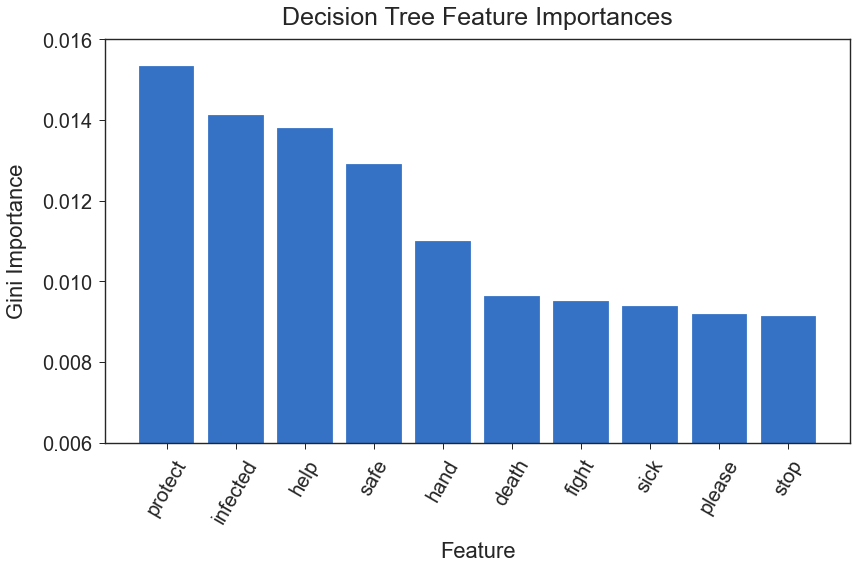

In [69]:
# top 10 most important features
tree_importance = [x[1] for x in sorted_d]

# prettify the graph
plt.figure(figsize=(12,8))
plt.title('Decision Tree Feature Importances', fontsize=25, pad=15)
plt.xlabel('Feature', fontsize=22, labelpad=15)
plt.ylabel('Gini Importance', fontsize=22, labelpad=15)
plt.ylim(bottom=0.006, top=0.016)
plt.xticks(rotation=60, fontsize=20)
plt.yticks(fontsize=20)

# plot
plt.bar([x[0] for x in sorted_d], tree_importance)

# # prepare to display and save
plt.tight_layout()
# uncomment to save
plt.savefig('charts/tuned_tree_feature_importance.png', bbox_inches='tight', transparent=True)

plt.show()

### Confusion Matrix

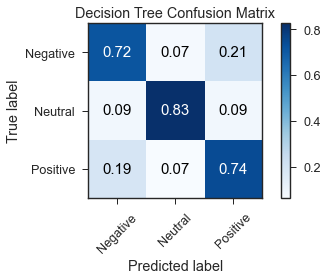

In [70]:
cm_tree = confusion_matrix(y_test, y_pred_tree_vec_tuned)
classes = ['Negative', 'Neutral', 'Positive']
plot_confusion_matrix(cm_tree, classes, normalize=True,
                      title='Decision Tree Confusion Matrix', cmap=plt.cm.Blues)

# plt.savefig('Images/dt_conf_matrix.png', dpi = 100)

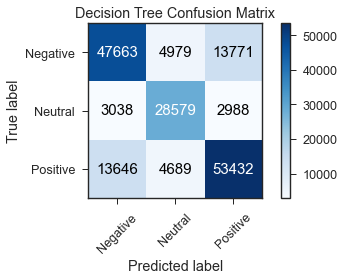

In [71]:
cm_tree = confusion_matrix(y_test, y_pred_tree_vec_tuned)
classes = ['Negative', 'Neutral', 'Positive']
plot_confusion_matrix(cm_tree, classes, normalize=False,
                      title='Decision Tree Confusion Matrix', cmap=plt.cm.Blues)

# plt.savefig('Images/dt_conf_matrix.png', dpi = 100)

In [ ]:
import spacy

In [ ]:
%%time 

nlp = spacy.load('en_core_web_md')

In [ ]:
%%time

df['spacy'] = df.clean_tweet.apply(lambda x: nlp(x))

In [ ]:
df.isna().sum()

In [ ]:
df.columns

In [ ]:
df[df.clean_tweet.isna()]

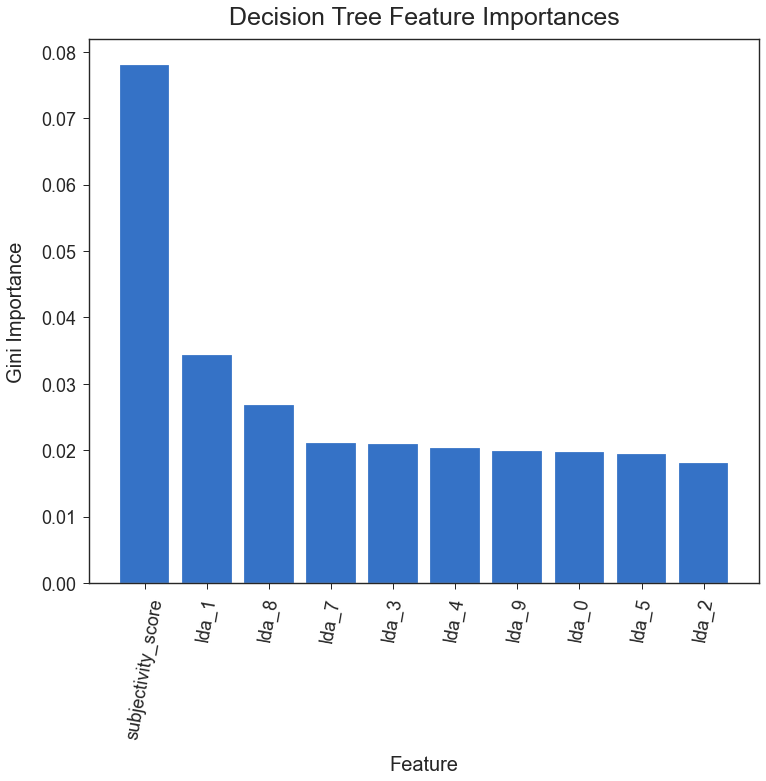

In [37]:
# top 10 most important features
tree_importance = [x[1] for x in sorted_d]

plt.figure(figsize=(12,10))
plt.title('Decision Tree Feature Importances', fontsize=25, pad=15)
plt.xlabel('Feature', fontsize=20, labelpad=15)
plt.ylabel('Gini Importance', fontsize=20, labelpad=15)

plt.bar([x[0] for x in sorted_d], tree_importance)
plt.xticks(rotation=80, fontsize=18)
plt.yticks(fontsize=18)
plt.show()

In [61]:
help(tree_vec.tree_)

Help on Tree object:

class Tree(builtins.object)
 |  Array-based representation of a binary decision tree.
 |  
 |  The binary tree is represented as a number of parallel arrays. The i-th
 |  element of each array holds information about the node `i`. Node 0 is the
 |  tree's root. You can find a detailed description of all arrays in
 |  `_tree.pxd`. NOTE: Some of the arrays only apply to either leaves or split
 |  nodes, resp. In this case the values of nodes of the other type are
 |  arbitrary!
 |  
 |  Attributes
 |  ----------
 |  node_count : int
 |      The number of nodes (internal nodes + leaves) in the tree.
 |  
 |  capacity : int
 |      The current capacity (i.e., size) of the arrays, which is at least as
 |      great as `node_count`.
 |  
 |  max_depth : int
 |      The depth of the tree, i.e. the maximum depth of its leaves.
 |  
 |  children_left : array of int, shape [node_count]
 |      children_left[i] holds the node id of the left child of node i.
 |      For leave

In [60]:
print(tree_vec.tree_.max_depth)

3265


In [56]:
y_pred_train = tree_vec.predict(X_train_mm_vec)
accuracy_score(y_train, y_pred_train)

0.9965225069698683

In [50]:
from sklearn import tree

RecursionError: maximum recursion depth exceeded while getting the repr of an object

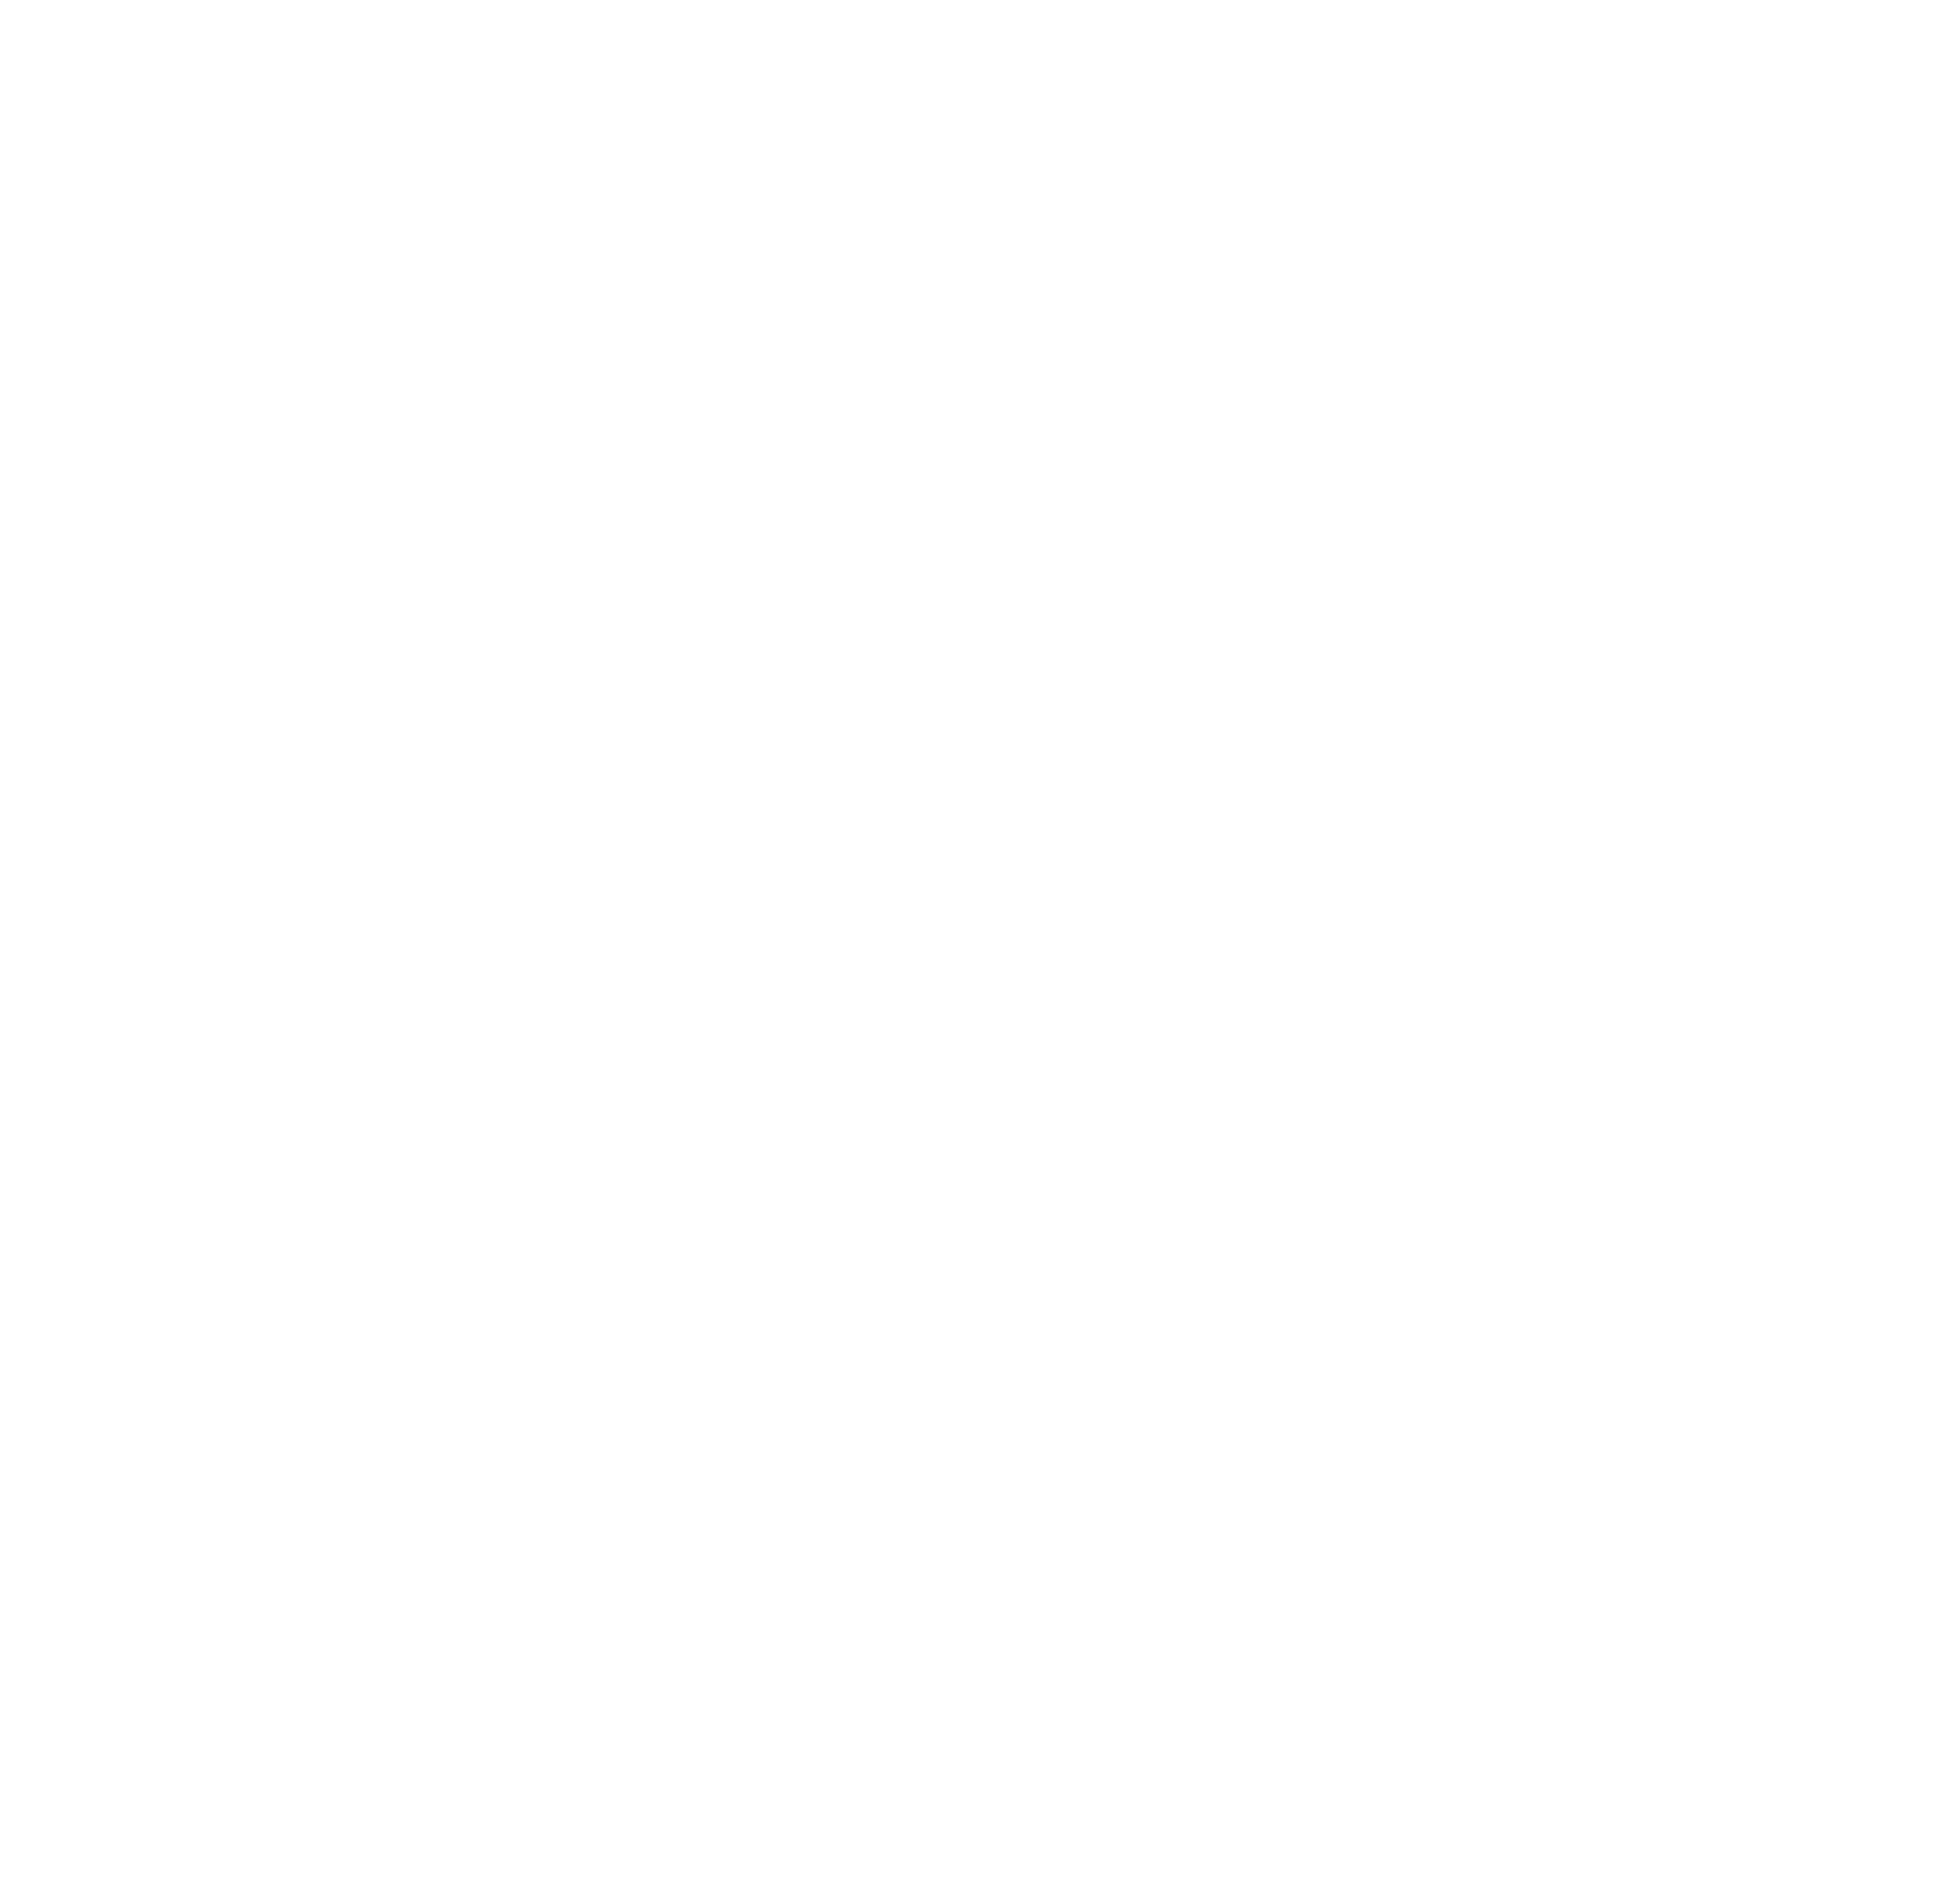

In [51]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10,10), dpi=300)

tree.plot_tree(tree_vec,
               feature_names=X.iloc[:,13:].columns, 
               class_names=['negative', 'neutral', 'positive'],
               filled=True);

fig.savefig('imagename.png')

In [53]:
from io import StringIO
from sklearn.tree import export_graphviz
from IPython.display import Image  
import pydotplus

In [55]:
# Create DOT data
dot_data = export_graphviz(tree_vec, out_file=None, 
                            feature_names=X.iloc[:,13:].columns, 
                            class_names=['negative', 'neutral', 'positive'],
                            filled=True, rounded=True, special_characters=True)

# Draw graph
graph = pydotplus.graph_from_dot_data(dot_data)  

# Show graph
Image(graph.create_png())

RecursionError: maximum recursion depth exceeded while getting the repr of an object

In [ ]:
# dot_data = StringIO()
dot_data = export_graphviz(tree, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,
                feature_names=X.columns,
                class_names=['negative','neutral', 'positive'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('charts/decision_twee.png')
Image(graph.create_png())